## Persistence Landscapes

- vectorized representations of persistence diagrams

- per homology group rank (ex H0, H1, or H2)
- per stimuli
- per region
- difference landscapes

Author: @emilyekstrum
<br> 11/26/25

In [16]:
# import modules
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from persim import PersLandscapeApprox
from persim import persistent_entropy
from persim.landscapes import average_approx
from persim.landscapes import snap_pl
from persim.landscapes import plot_landscape_simple
from persim.landscapes import plot_landscape
import random
import os
from matplotlib.lines import Line2D
import numpy as np
from typing import Optional, Tuple, Sequence, Any
from sklearn.decomposition import PCA
from ripser import ripser
from persim import wasserstein
from sklearn.neighbors import NearestNeighbors    
from scipy.sparse import coo_matrix    

In [17]:
# import TDA utilities
import sys
from pathlib import Path

repo_root = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
if str(repo_root) not in sys.path:
    sys.path.insert(0, str(repo_root))

try:
    from tda_utils import TDADataManager, tda_manager
    print("TDA utilities loaded")
except ImportError as e:
    print(f"Could not import TDA utilities: {e}")
    print("Make sure you're running from the TDA repository.")
    raise

# initialize or use the global data manager
if tda_manager is not None:
    data_manager = tda_manager
else:
    data_manager = TDADataManager()

# summary of available data
data_manager.print_summary()

TDA utilities loaded
TDA Data Manager Summary
Workspace root: /Users/emilyekstrum/repos/TDA
Data directory: /Users/emilyekstrum/repos/TDA/data
  - clean_spike_data_zip: clean_spike_data.zip
  - clean_spike_data_dir: clean_spike_data
      Contains 8 .pkl files
  - cebra_examples: CEBRA_embedding_examples
      Contains 4 .pkl files
  - persistence_examples: persistence_diagram_examples
      Contains 22 .pkl files
  - all_dgms_zip: all_dgms.zip
  X all_dgms_dir: all_dgms

Available spike datasets (8):
  • LGNchromatic_gratings.pkl
  • LGNcolor_exchange.pkl
  • LGNdrifting_gratings.pkl
  • LGNluminance_flash.pkl
  • V1chromatic_gratings.pkl
  and 3 more


# for plots
- x axis = filtration parameter (midpoint of feature (death - birth)/2)
- y axis = "feature persistence strength" (half-life of feature (birth+death)/2)

In [18]:
# set primary data directory based on available files
all_persistence_files = data_manager.find_files("*.pkl", "persistence_examples")

if all_persistence_files:
    # use the directory of the first file as primary, but search all
    data_dir = all_persistence_files[0].parent
    print(f"Primary data directory: {data_dir}")
    print(f"Total persistence files available: {len(all_persistence_files)}")
    
    # check if there are files from all_dgms (more comprehensive dataset)
    all_dgms_files = [f for f in all_persistence_files if 'all_dgms' in str(f)]
    if all_dgms_files:
        print(f"Files from all_dgms.zip: {len(all_dgms_files)}")
    
    # check persistence_examples files
    examples_files = [f for f in all_persistence_files if 'persistence_diagram_examples' in str(f)]
    if examples_files:
        print(f"Files from persistence_examples: {len(examples_files)}")
        
else:
    # use original directory
    data_dir = data_manager.data_paths['persistence_examples']
    print(f"Getting dgms files from: {data_dir}")

# stimulus mapping 
stim_map = {
    "dg": "drifting_gratings",
    "cg": "chromatic_gratings",
    "cex": "color_exchange",
    "lf": "luminance_flash",
    "ng": "natural_gratings",
    "nm": "natural_movie",
    "rf": "receptive_field",
    "sp": "sparse_noise"
}

def parse_filename(fname: str):
    """ Enhanced filename parser for comprehensive dataset support.
    
    Args:
        fname (str): filename
    Returns:
        dict: method, embed_dim, region, stim, mouse"""

    # TDA utils for parsing
    info = data_manager.parse_filename_info(fname)
    
    return {
        "method": "CEBRA",  
        "embed_dim": info['dimension'],
        "region": info['region'],
        "stim": info['stimulus'],
        "mouse": info['mouse_id'],
    }

def load_dgms(path):
    """ Enhanced diagram loader that works with all file sources.
    
    Args:
        path (str or Path): path to pickle file (can be relative name or full path)
    Returns:
        list: diagrams"""

    # handle full paths and filenames
    if isinstance(path, str) and not path.startswith('/'):
        # find the full path of file name
        matching_files = [f for f in all_persistence_files if f.name == path]
        if matching_files:
            path = matching_files[0]
        else:
            # try in the primary data directory
            path = data_dir / path
    
    return data_manager.load_persistence_diagrams(path)

Primary data directory: /Users/emilyekstrum/repos/TDA/data/persistence_diagram_examples
Total persistence files available: 22
Files from persistence_examples: 22


In [19]:
# load all available persistence diagram files from multiple sources
available_files = data_manager.find_files("*.pkl", "persistence_examples")

if available_files:
    
    # organize by region, stimulus, and dimension 
    file_organization = {}
    dimension_counts = {}
    stimulus_counts = {}
    
    for file_path in available_files:
        info = data_manager.parse_filename_info(file_path)
        region = info['region']
        stimulus = info['stimulus']
        dimension = info['dimension']
        
        # count by categories
        key = f"{region}_{stimulus}"
        if key not in file_organization:
            file_organization[key] = []
        file_organization[key].append(file_path)
        
        # track dimensions and stimuli
        dimension_counts[dimension] = dimension_counts.get(dimension, 0) + 1
        stimulus_counts[stimulus] = stimulus_counts.get(stimulus, 0) + 1
    
    print(f"\nAvailable data combinations:")
    for combo, files in sorted(file_organization.items()):
        region, stim = combo.split('_', 1)
        dimensions_in_combo = sorted(set(data_manager.parse_filename_info(f)['dimension'] for f in files),
                                   key=lambda x: int(x[:-1]) if x[:-1].isdigit() else 999)
        print(f"  • {region} - {stim.replace('_', ' ').title()}: {len(files)} files ({', '.join(dimensions_in_combo)})")
        
    # separate lists for each region (maintaining backward compatibility)
    LGN_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'LGN']
    V1_files = [f.name for f in available_files if data_manager.parse_filename_info(f)['region'] == 'V1']
    
    print(f"\nCompatibility lists:")
    print(f"   LGN files: {len(LGN_files)}")
    print(f"   V1 files: {len(V1_files)}")
    
else:
    print("No persistence diagram files found.")
    print("Error checklist:")
    print("  1. Run the Ripser notebook (02_Ripser.ipynb) to generate persistence diagrams")
    print("  2. Put all_dgms.zip in the data/ directory")
    print("  3. Add .pkl files directly to data/persistence_diagram_examples/")
    LGN_files = []
    V1_files = []


Available data combinations:
  • LGN - Color Exchange: 8 files (3d, 8d, 24d, 32d)
  • V1 - Color Exchange: 14 files (3d, 8d, 24d, 32d)

Compatibility lists:
   LGN files: 8
   V1 files: 14


## By region

In [20]:
# average landscapes for each homology group (H0, H1, H2)
if available_files:
    
    avg_lgn_landscapes = {}
    avg_v1_landscapes = {}

    for hom_deg in range(3): 
        print(f"  Processing H{hom_deg}")
        LGN_landscape = []
        V1_landscape = []
        
        # LGN files
        lgn_count = 0
        for f in LGN_files:
            try:
                fpath = data_dir / f
                dgms = load_dgms(fpath)
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if dgms and len(dgms) > hom_deg:
                    if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        LGN_landscape.append(persistence_landscape)
                        lgn_count += 1
            except Exception as e:
                print(f"    Error processing {f}: {e}")
                continue
        
        # V1 files
        v1_count = 0
        for f in V1_files:
            try:
                fpath = data_dir / f
                dgms = load_dgms(fpath)
                if isinstance(dgms, np.ndarray):
                    dgms = dgms.tolist()
                if dgms and len(dgms) > hom_deg:
                    if dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                        persistence_landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        V1_landscape.append(persistence_landscape)
                        v1_count += 1
            except Exception as e:
                print(f"    Error processing {f}: {e}")
                continue
        
        # average persistence landscapes 
        if LGN_landscape:
            avg_lgn_landscapes[f'H{hom_deg}'] = average_approx(LGN_landscape)
            print(f"    LGN H{hom_deg}: {lgn_count} landscapes averaged")
        if V1_landscape:
            avg_v1_landscapes[f'H{hom_deg}'] = average_approx(V1_landscape)
            print(f"    V1 H{hom_deg}: {v1_count} landscapes averaged")

    # save individual landscape variables
    avg_lgn_h0_landscape = avg_lgn_landscapes.get('H0')
    avg_lgn_h1_landscape = avg_lgn_landscapes.get('H1')
    avg_lgn_h2_landscape = avg_lgn_landscapes.get('H2')
    avg_v1_h0_landscape = avg_v1_landscapes.get('H0')
    avg_v1_h1_landscape = avg_v1_landscapes.get('H1')
    avg_v1_h2_landscape = avg_v1_landscapes.get('H2')
    
else:
    print("No files available for landscape computation.")

  Processing H0
    LGN H0: 8 landscapes averaged
    LGN H0: 8 landscapes averaged
    V1 H0: 14 landscapes averaged
  Processing H1
    V1 H0: 14 landscapes averaged
  Processing H1
    LGN H1: 8 landscapes averaged
    V1 H1: 14 landscapes averaged
  Processing H2
    LGN H2: 8 landscapes averaged
    V1 H2: 14 landscapes averaged
    LGN H1: 8 landscapes averaged
    V1 H1: 14 landscapes averaged
  Processing H2
    LGN H2: 8 landscapes averaged
    V1 H2: 14 landscapes averaged


## 🎨 Enhanced Landscape Plotting

This section provides enhanced plotting capabilities for recreating and customizing the persistence landscape visualizations.

In [21]:
def create_enhanced_landscape_plot(landscapes_dict, title="Enhanced Persistence Landscapes", 
                                  figsize=(18, 10), save_path=None, show_counts=True):
    """
    Enhanced function to recreate and customize the persistence landscape plot.
    
    Args:
        landscapes_dict (dict): Dictionary with structure {region: {homology_group: landscape}}
        title (str): Main title for the plot
        figsize (tuple): Figure size (width, height)
        save_path (str): Path to save the plot (optional)
        show_counts (bool): Whether to show diagram counts on plots
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    
    # Validate input data
    if not landscapes_dict:
        print("❌ No landscape data provided")
        return None
    
    # Setup the plot structure
    regions = list(landscapes_dict.keys())
    homology_groups = ['H0', 'H1', 'H2']
    
    fig, axes = plt.subplots(len(regions), len(homology_groups), figsize=figsize)
    if len(regions) == 1:
        axes = axes.reshape(1, -1)
    
    # Color scheme for landscape layers
    colors = [plt.cm.viridis(i/3) for i in range(3)]
    
    # Calculate global axis limits for consistent scaling
    all_x_values, all_y_values = [], []
    for region in regions:
        for group in homology_groups:
            landscape = landscapes_dict[region].get(group)
            if landscape is not None:
                try:
                    # Extract x values (filtration parameter)
                    if hasattr(landscape, 'grid'):
                        xs = landscape.grid
                    elif hasattr(landscape, 'xs'):
                        xs = landscape.xs
                    else:
                        xs = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
                    
                    # Extract y values (persistence values)
                    if hasattr(landscape, 'landscapes'):
                        landscapes_data = landscape.landscapes
                    elif hasattr(landscape, 'values'):
                        landscapes_data = landscape.values
                    else:
                        landscapes_data = landscape.Ls
                    
                    all_x_values.extend(xs)
                    for layer in landscapes_data[:3]:  # First 3 layers
                        all_y_values.extend(layer)
                except Exception:
                    continue
    
    # Set consistent axis limits
    if all_x_values and all_y_values:
        x_min, x_max = min(all_x_values), max(all_x_values)
        y_min, y_max = max(0, min(all_y_values)), max(all_y_values)
        
        # Add padding
        x_padding = (x_max - x_min) * 0.05
        y_padding = (y_max - y_min) * 0.05
        x_limits = (x_min - x_padding, x_max + x_padding)
        y_limits = (y_min - y_padding, y_max + y_padding)
    else:
        x_limits = (0, 1)
        y_limits = (0, 0.03)
    
    # Create the plots
    for row_idx, region in enumerate(regions):
        for col_idx, group in enumerate(homology_groups):
            ax = axes[row_idx, col_idx]
            landscape = landscapes_dict[region].get(group)
            
            if landscape is not None:
                try:
                    # Set current axis for persim plotting
                    plt.sca(ax)
                    
                    # Plot the landscape with custom depth
                    plot_landscape_simple(landscape, title="", depth_range=range(3))
                    
                    # Remove individual legends
                    legend = ax.get_legend()
                    if legend:
                        legend.remove()
                    
                    # Apply consistent axis limits
                    ax.set_xlim(x_limits)
                    ax.set_ylim(y_limits)
                    
                    # Add count information if requested
                    if show_counts and 'diagram_counts' in globals():
                        count = diagram_counts.get(region, {}).get(group, 0)
                        ax.text(0.02, 0.98, f'n={count}', transform=ax.transAxes, 
                               fontsize=10, verticalalignment='top',
                               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                    
                except Exception as e:
                    print(f"Error plotting {region} {group}: {e}")
                    ax.text(0.5, 0.5, f'Error\n{region} {group}', 
                           transform=ax.transAxes, ha='center', va='center')
            else:
                # No data available
                ax.text(0.5, 0.5, f'No Data\n{region} {group}', 
                       transform=ax.transAxes, ha='center', va='center',
                       fontsize=12, alpha=0.7)
                ax.set_xlim(x_limits)
                ax.set_ylim(y_limits)
            
            # Styling
            ax.tick_params(axis='both', labelsize=14)
            ax.grid(True, alpha=0.3)
            
            # Labels
            if row_idx == 0:
                ax.set_title(group, fontsize=18, fontweight='bold')
            if col_idx == 0:
                ax.set_ylabel(f"$\\mathbf{{{region}}}$\nFeature Persistence", 
                             fontsize=16, fontweight='bold')
            if row_idx == len(regions) - 1:
                ax.set_xlabel("Filtration Parameter", fontsize=14)
    
    # Global legend
    handles = [Line2D([0], [0], color=colors[i], linewidth=2.5) for i in range(3)]
    labels = [f'λ{i}' for i in range(3)]
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.02, 0.5), 
              title='Landscape\nLayers', fontsize=14, title_fontsize=16)
    
    # Main title
    fig.suptitle(title, fontsize=20, fontweight='bold', y=0.98)
    
    # Layout adjustment
    plt.tight_layout(rect=[0, 0, 0.95, 0.96])
    
    # Save if requested
    if save_path:
        try:
            output_path = data_manager.get_output_path(save_path, "analysis_results")
            plt.savefig(output_path, dpi=300, bbox_inches='tight')
            print(f"📁 Plot saved to: {output_path}")
        except Exception as e:
            print(f"❌ Error saving plot: {e}")
    
    return fig


def recreate_original_landscape_plot():
    """
    Recreate the exact plot from your output using the enhanced plotting function.
    """
    
    # Check if we have the necessary landscape data
    if not (available_files and 'avg_lgn_landscapes' in locals() and 'avg_v1_landscapes' in locals()):
        print("❌ Landscape data not available. Run the landscape computation cells first.")
        return None
    
    # Organize data in the required format
    landscapes_data = {
        'LGN': {
            'H0': avg_lgn_landscapes.get('H0'),
            'H1': avg_lgn_landscapes.get('H1'),
            'H2': avg_lgn_landscapes.get('H2')
        },
        'V1': {
            'H0': avg_v1_landscapes.get('H0'),
            'H1': avg_v1_landscapes.get('H1'),
            'H2': avg_v1_landscapes.get('H2')
        }
    }
    
    # Create the enhanced plot
    print("🎨 Creating enhanced landscape visualization...")
    fig = create_enhanced_landscape_plot(
        landscapes_data,
        title="Average Persistence Landscapes by Region and Homology Group",
        figsize=(18, 10),
        save_path="enhanced_landscapes_by_region.png",
        show_counts=True
    )
    
    if fig:
        plt.show()
        return fig
    else:
        print("❌ Failed to create plot")
        return None


# Execute the recreation
if available_files:
    print("🔄 Recreating the persistence landscape plot...")
    recreated_fig = recreate_original_landscape_plot()
else:
    print("❌ No data available for plot recreation")

🔄 Recreating the persistence landscape plot...
❌ Landscape data not available. Run the landscape computation cells first.


## 🎛️ Customizable Plot Variants

Create different versions of the landscape plot with various customizations:

🎨 Creating customized landscape visualizations...

📊 H1-focused landscape plot:
📁 Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/h1_landscapes_comparison.png
📁 Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/h1_landscapes_comparison.png


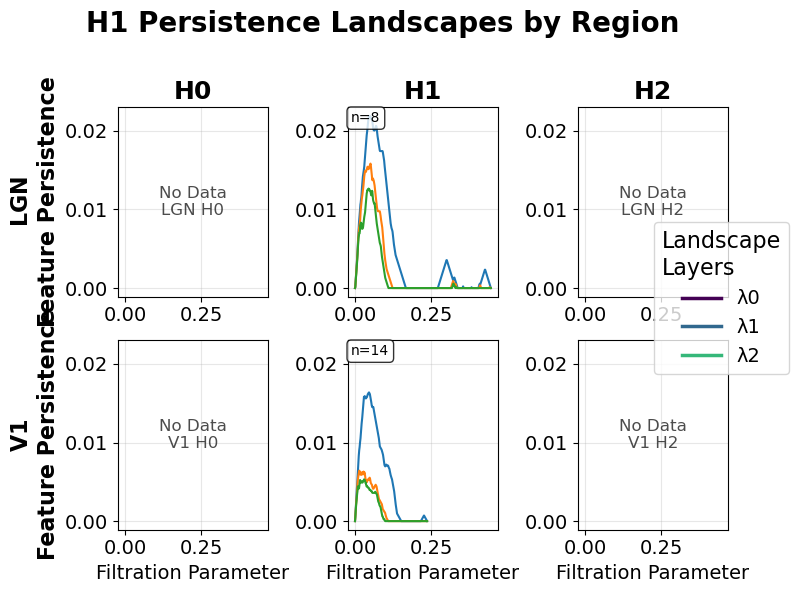


📊 Compact landscape plot:


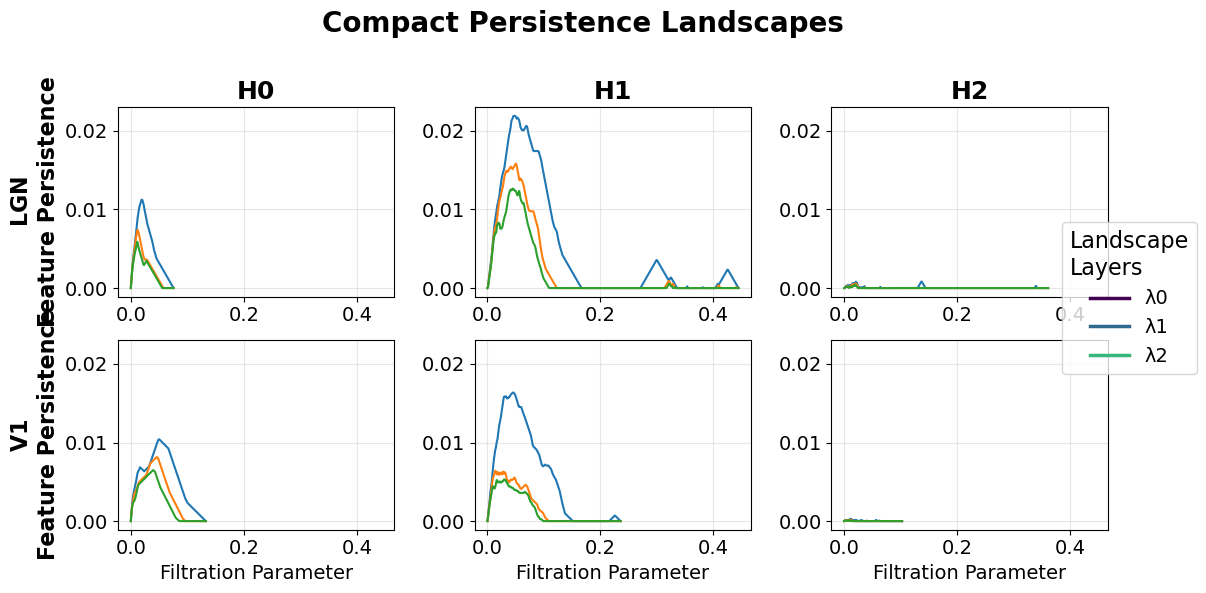


📊 Publication-ready landscape plot:
📁 Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/publication_landscapes.png
📁 Plot saved to: /Users/emilyekstrum/repos/TDA/data/analysis_results/publication_landscapes.png


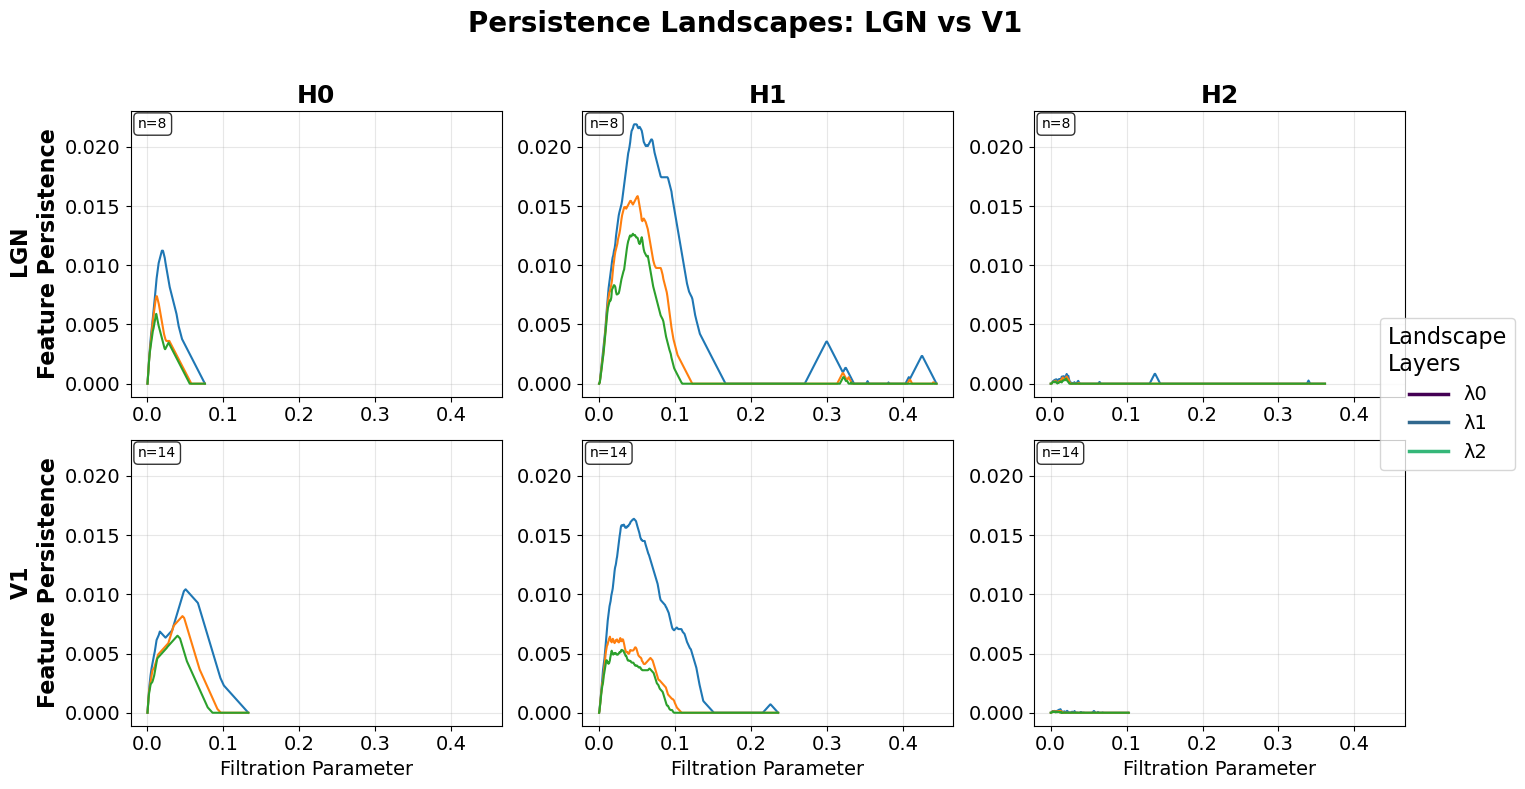


✅ All landscape plot variants created successfully!


In [22]:
# Create multiple plot variants
if available_files and 'avg_lgn_landscapes' in locals() and 'avg_v1_landscapes' in locals():
    
    landscapes_data = {
        'LGN': avg_lgn_landscapes,
        'V1': avg_v1_landscapes
    }
    
    print("🎨 Creating customized landscape visualizations...")
    
    # Variant 1: Focus on H1 only
    h1_data = {region: {'H1': data.get('H1')} for region, data in landscapes_data.items()}
    if any(h1_data[region]['H1'] is not None for region in h1_data):
        print("\n📊 H1-focused landscape plot:")
        fig1 = create_enhanced_landscape_plot(
            h1_data,
            title="H1 Persistence Landscapes by Region",
            figsize=(8, 6),
            save_path="h1_landscapes_comparison.png"
        )
        plt.show()
    
    # Variant 2: Compact version with smaller size
    print("\n📊 Compact landscape plot:")
    fig2 = create_enhanced_landscape_plot(
        landscapes_data,
        title="Compact Persistence Landscapes",
        figsize=(12, 6),
        show_counts=False
    )
    plt.show()
    
    # Variant 3: Publication-ready version
    print("\n📊 Publication-ready landscape plot:")
    plt.style.use('default')  # Ensure clean style
    fig3 = create_enhanced_landscape_plot(
        landscapes_data,
        title="Persistence Landscapes: LGN vs V1",
        figsize=(15, 8),
        save_path="publication_landscapes.png",
        show_counts=True
    )
    plt.show()
    
    print("\n✅ All landscape plot variants created successfully!")
    
else:
    print("❌ Landscape data not available for creating variants")

## 📊 Interactive Plot Information

Get detailed information about your landscape plots:

Comparing dimensions: ['3d', '8d', '24d', '32d']
Target stimulus: ['color_exchange']
Target region: V1
  3d: Average landscape created from 10 files
  8d: Average landscape created from 2 files
  24d: Average landscape created from 1 files
  32d: Average landscape created from 1 files
  3d: Average landscape created from 10 files
  8d: Average landscape created from 2 files
  24d: Average landscape created from 1 files
  32d: Average landscape created from 1 files


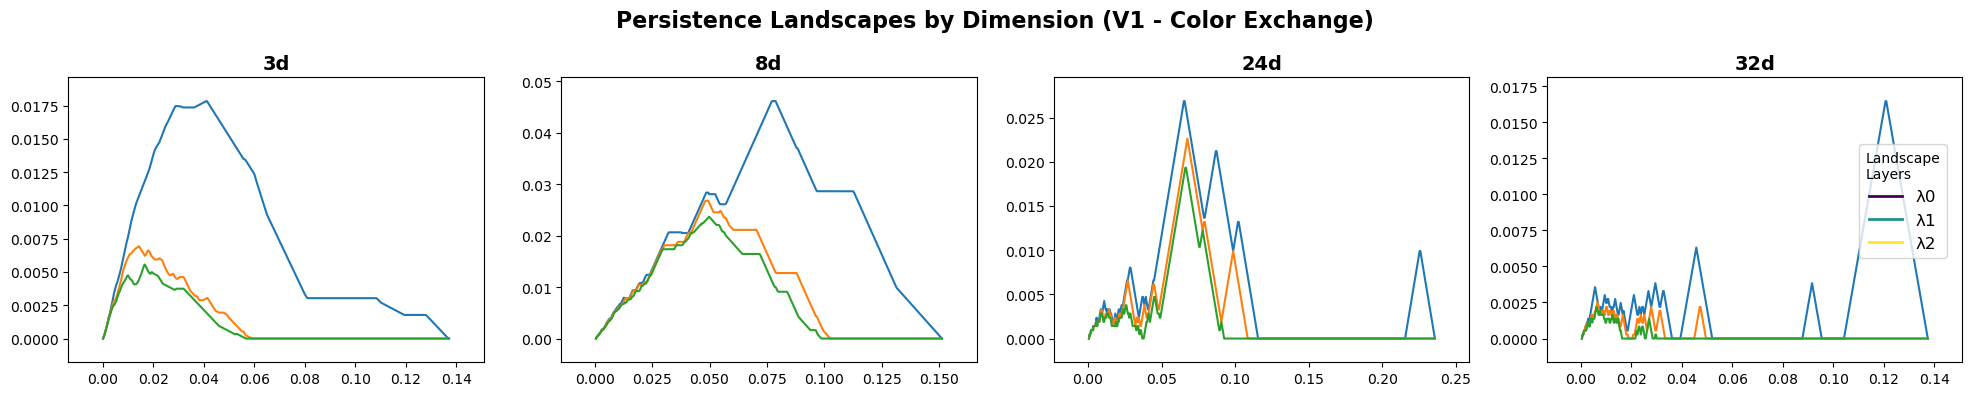

In [23]:
if available_files:
    
    # get dimensions fpr plotting
    all_dims = sorted(set(data_manager.parse_filename_info(f)['dimension'] for f in available_files),
                     key=lambda x: int(x[:-1]) if x[:-1].isdigit() else 999)
    
    target_stimuli = ['color_exchange']  # one stimulus for dimension comparison
    target_region = 'V1'  # one region
    hom_deg = 1  # chnage to adjust homology group
    
    print(f"Comparing dimensions: {all_dims}")
    print(f"Target stimulus: {target_stimuli}")
    print(f"Target region: {target_region}")
    
    dimension_landscapes = {}
    
    for dim in all_dims:
        
        # filter by dimension, region, and stimulus
        dim_files = []
        for file_path in available_files:
            info = data_manager.parse_filename_info(file_path)
            if (info['dimension'] == dim and 
                info['region'] == target_region and 
                info['stimulus'] in target_stimuli):
                dim_files.append(file_path)
        
        if dim_files:
            landscapes = []
            for fpath in dim_files:
                try:
                    dgms = load_dgms(fpath)
                    if isinstance(dgms, np.ndarray):
                        dgms = dgms.tolist()
                    if dgms and len(dgms) > hom_deg and dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0:
                        landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                        landscapes.append(landscape)
                except Exception as e:
                    print(f"    Error processing {fpath.name}: {e}")
                    continue
            
            if landscapes:
                try:
                    avg_landscape = average_approx(landscapes)
                    dimension_landscapes[f'{dim}'] = avg_landscape
                    print(f"  {dim}: Average landscape created from {len(landscapes)} files")
                except Exception as e:
                    print(f"  {dim}: Failed to create average - {e}")
            else:
                print(f"   {dim}: No valid landscapes generated")
        else:
            print(f"   {dim}: No files found")
    
    # plot if there is data
    if dimension_landscapes:        
        n_dims = len(dimension_landscapes)
        cols = min(4, n_dims)
        rows = (n_dims + cols - 1) // cols
        
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4*rows))
        if n_dims == 1:
            axes = [axes]
        elif rows == 1:
            axes = [axes] if n_dims == 1 else axes
        else:
            axes = axes.flatten()
        
        for i, (dim_name, landscape) in enumerate(dimension_landscapes.items()):
            ax = axes[i] if n_dims > 1 else axes[0]
            
            try:
                plt.sca(ax)
                plot_landscape_simple(landscape, title="", depth_range=range(3))
                ax.set_title(f"{dim_name}", fontsize=14, fontweight='bold')
                
                legend = ax.get_legend()
                if legend:
                    legend.remove()
                    
            except Exception as e:
                ax.text(0.5, 0.5, f'Plotting Error\n{dim_name}\n{str(e)[:30]}', 
                       ha='center', va='center', transform=ax.transAxes)
        
        for j in range(n_dims, len(axes)):
            axes[j].axis('off')
        
        # legend
        handles = [plt.Line2D([0], [0], color=plt.cm.viridis(i/2), linewidth=2) for i in range(3)]
        labels = [f'λ{i}' for i in range(3)]
        fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5), 
                  title='Landscape\nLayers', fontsize=12)
        
        plt.suptitle(f'Persistence Landscapes by Dimension ({target_region} - {target_stimuli[0].replace("_", " ").title()})', 
                    fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("\nNo dimensional landscapes available for comparison.")
        print(f"   Check if files exist for region '{target_region}' and stimulus '{target_stimuli[0]}'")
        
else:
    print("No data available for multi-dimensional analysis.")

## 📊 Comprehensive Landscape Metrics Analysis

Analyze topological metrics (AUC, peak position, layer count) across embedding dimensions and stimuli

In [24]:
def extract_landscape_metrics(landscape, metric_type='all'):
    """
    Extract various metrics from a persistence landscape.
    
    Args:
        landscape: PersLandscapeApprox object
        metric_type: 'all', 'auc', 'peak_position', or 'layer_count'
    
    Returns:
        dict: Dictionary containing the requested metrics
    """
    metrics = {}
    
    if landscape is None:
        return {'auc': 0.0, 'peak_position': 0.0, 'layer_count': 0}
    
    try:
        # Extract landscape data
        if hasattr(landscape, 'landscapes'):
            landscapes_data = landscape.landscapes
        elif hasattr(landscape, 'values'):
            landscapes_data = landscape.values
        else:
            landscapes_data = landscape.Ls
        
        # Extract grid
        if hasattr(landscape, 'grid'):
            grid = landscape.grid
        else:
            grid = np.linspace(landscape.start, landscape.stop, landscape.num_steps)
        
        # AUC calculation
        if metric_type in ['all', 'auc']:
            auc_total = 0.0
            for i, layer in enumerate(landscapes_data[:3]):  # First 3 layers
                if len(layer) > 0:
                    auc_layer = np.trapz(np.maximum(layer, 0), grid)
                    auc_total += auc_layer
            metrics['auc'] = auc_total
        
        # Peak position (λ₀ peak magnitude)
        if metric_type in ['all', 'peak_position']:
            if len(landscapes_data) > 0 and len(landscapes_data[0]) > 0:
                layer_0 = landscapes_data[0]
                peak_position = np.max(layer_0) if len(layer_0) > 0 else 0.0
            else:
                peak_position = 0.0
            metrics['peak_position'] = peak_position
        
        # Layer count (number of active landscape layers)
        if metric_type in ['all', 'layer_count']:
            layer_count = 0
            for layer in landscapes_data:
                if len(layer) > 0 and np.max(layer) > 1e-6:  # Threshold for "active" layer
                    layer_count += 1
            metrics['layer_count'] = layer_count
        
    except Exception as e:
        print(f"Error extracting metrics: {e}")
        metrics = {'auc': 0.0, 'peak_position': 0.0, 'layer_count': 0}
    
    return metrics


def compute_comprehensive_landscape_metrics():
    """
    Compute comprehensive landscape metrics across all available data.
    """
    
    if not available_files:
        print("❌ No persistence diagram files available")
        return None, None
    
    print("🔬 Computing comprehensive landscape metrics...")
    
    # Initialize data collection
    topo_metrics_data = []
    
    # Get all unique dimensions, stimuli, and regions
    all_dimensions = sorted(set(data_manager.parse_filename_info(f)['dimension'] for f in available_files),
                           key=lambda x: int(x[:-1]) if x[:-1].isdigit() else 999)
    all_stimuli = sorted(set(data_manager.parse_filename_info(f)['stimulus'] for f in available_files))
    all_regions = sorted(set(data_manager.parse_filename_info(f)['region'] for f in available_files))
    
    print(f"Processing: {len(all_dimensions)} dimensions × {len(all_stimuli)} stimuli × {len(all_regions)} regions")
    
    # Process each combination
    for region in all_regions:
        for stimulus in all_stimuli:
            for dimension in all_dimensions:
                # Skip unknown categories
                if region == 'unknown' or stimulus == 'unknown' or dimension == 'unknown':
                    continue
                
                # Find matching files
                matching_files = []
                for file_path in available_files:
                    info = data_manager.parse_filename_info(file_path)
                    if (info['region'] == region and 
                        info['stimulus'] == stimulus and 
                        info['dimension'] == dimension):
                        matching_files.append(file_path)
                
                if not matching_files:
                    continue
                
                # Process each homology degree
                for hom_deg in range(3):
                    landscapes = []
                    diagram_count = 0
                    
                    for file_path in matching_files:
                        try:
                            dgms = load_dgms(file_path)
                            if isinstance(dgms, np.ndarray):
                                dgms = dgms.tolist()
                            
                            if (dgms and len(dgms) > hom_deg and 
                                dgms[hom_deg] is not None and len(dgms[hom_deg]) > 0):
                                landscape = PersLandscapeApprox(dgms=dgms, hom_deg=hom_deg)
                                landscapes.append(landscape)
                                diagram_count += len(dgms[hom_deg])
                        except Exception as e:
                            print(f"    Error processing {file_path.name}: {e}")
                            continue
                    
                    if landscapes:
                        try:
                            # Compute average landscape
                            avg_landscape = average_approx(landscapes)
                            
                            # Extract metrics
                            metrics = extract_landscape_metrics(avg_landscape)
                            
                            # Store results
                            topo_metrics_data.append({
                                'region': region,
                                'stimulus': stimulus,
                                'dimension': dimension,
                                'dimension_numeric': int(dimension.replace('d', '')) if dimension.replace('d', '').isdigit() else 0,
                                'homology_degree': hom_deg,
                                'auc': metrics['auc'],
                                'peak_position': metrics['peak_position'],
                                'layer_count': metrics['layer_count'],
                                'landscape_count': len(landscapes),
                                'diagram_count': diagram_count
                            })
                            
                        except Exception as e:
                            print(f"    Error computing average landscape: {e}")
                            continue
    
    # Convert to DataFrame
    topo_metrics_df = pd.DataFrame(topo_metrics_data)
    
    if topo_metrics_df.empty:
        print("❌ No metrics computed")
        return None, None
    
    # Compute summary statistics
    summary_data = []
    
    for (region, stimulus, dimension, hom_deg), group in topo_metrics_df.groupby(['region', 'stimulus', 'dimension', 'homology_degree']):
        summary_data.append({
            'region': region,
            'stimulus': stimulus.replace('_', ' ').title(),
            'dimension': dimension,
            'dimension_numeric': int(dimension.replace('d', '')) if dimension.replace('d', '').isdigit() else 0,
            'homology_degree': hom_deg,
            'auc_mean': group['auc'].mean(),
            'auc_std': group['auc'].std(),
            'peak_position_mean': group['peak_position'].mean(),
            'peak_position_std': group['peak_position'].std(),
            'layer_count_mean': group['layer_count'].mean(),
            'layer_count_std': group['layer_count'].std(),
            'diagram_count': group['diagram_count'].sum()
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    print(f"✅ Computed metrics for {len(topo_metrics_df)} landscape combinations")
    print(f"📊 Summary statistics for {len(summary_df)} groups")
    
    return topo_metrics_df, summary_df


# Execute the comprehensive analysis
if available_files:
    topo_metrics_df, summary_df = compute_comprehensive_landscape_metrics()
else:
    print("❌ No data available for comprehensive metrics analysis")
    topo_metrics_df, summary_df = None, None

🔬 Computing comprehensive landscape metrics...
Processing: 4 dimensions × 1 stimuli × 2 regions


/var/folders/st/2v00q15s7bb4yr2r5ghl_42r0000gn/T/ipykernel_97772/2412822180.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_layer = np.trapz(np.maximum(layer, 0), grid)


✅ Computed metrics for 24 landscape combinations
📊 Summary statistics for 24 groups


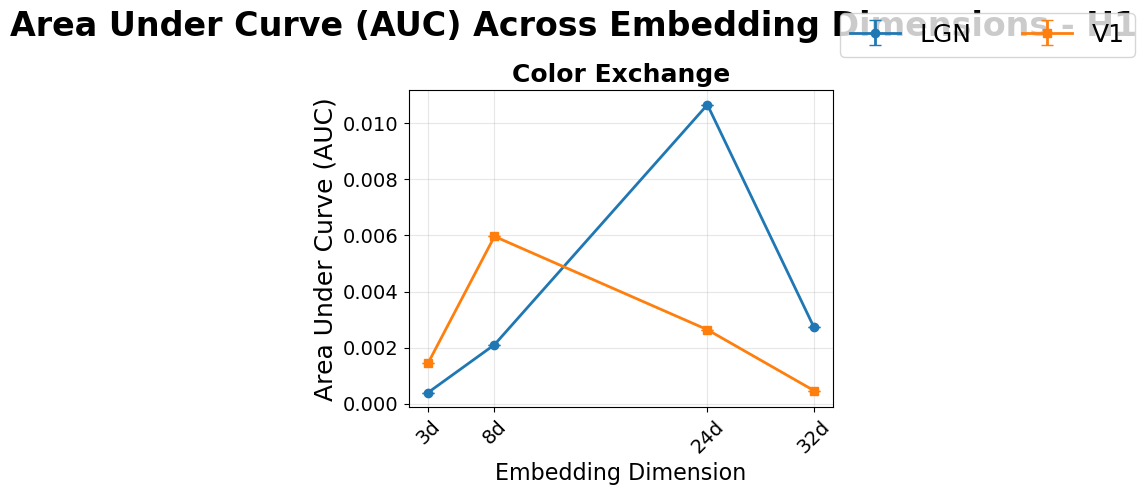

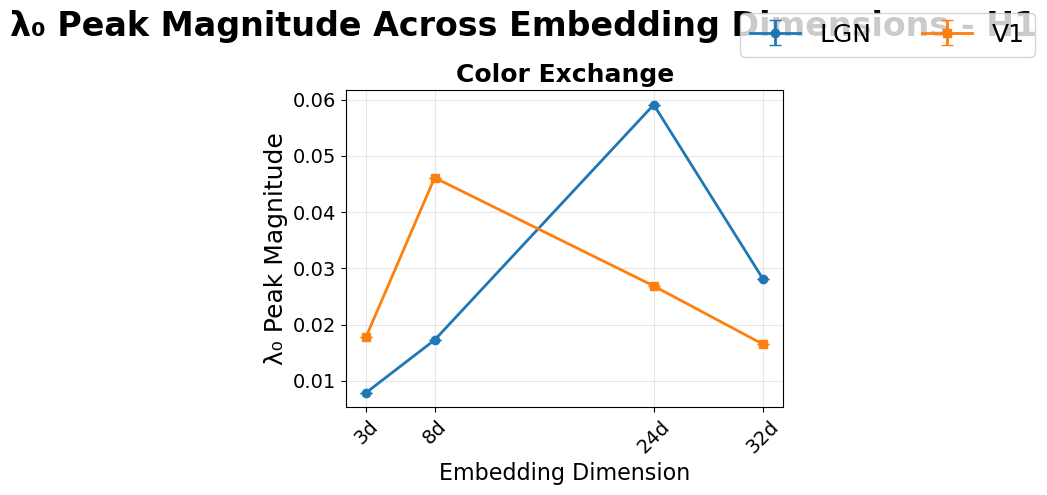

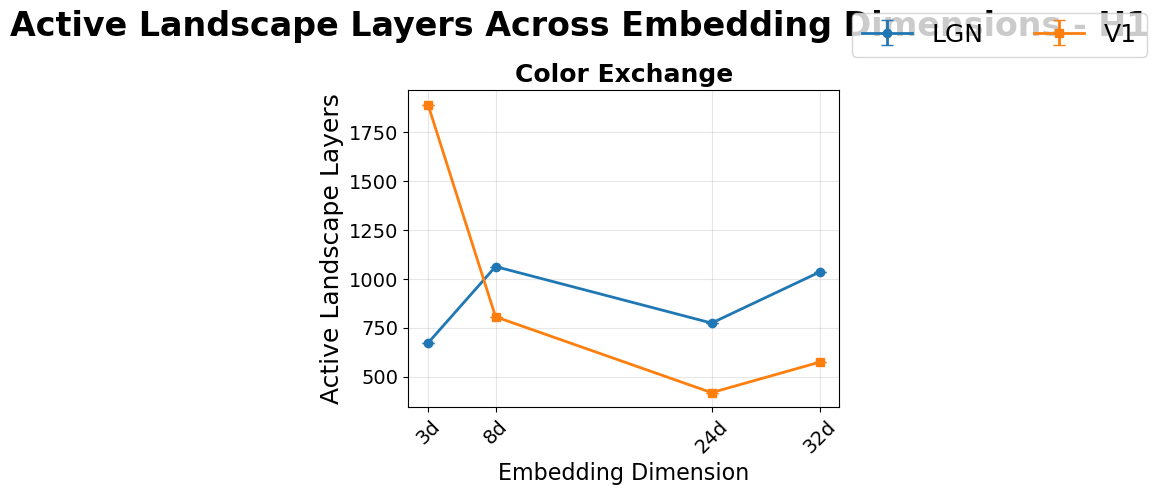

In [28]:
# plots for AUC, peak position, and layer count across embedding dimensions

if topo_metrics_df is None or summary_df is None or topo_metrics_df.empty or summary_df.empty:
    print('No data available for plotting metrics across embedding dimensions.')
else:
    # config
    hom_deg = 1  # change for other homology groups (0, 1, 2)
    
    # filter data for the homology group
    filtered_summary = summary_df[summary_df['homology_degree'] == hom_deg].copy()
    
    if filtered_summary.empty:
        print(f"No data available for homology degree H{hom_deg}")
    else:
        # dimensions and stimuli
        embedding_dims = sorted(filtered_summary['dimension'].unique(), 
                              key=lambda x: int(x.replace('d', '')) if x.replace('d', '').isdigit() else 0)
        dim_numeric_order = [int(d.replace('d', '')) for d in embedding_dims]
        dim_label_map = dict(zip(dim_numeric_order, embedding_dims))
        
        # stimulus mapping
        comprehensive_stimulus_mapping = {
            'Color Exchange': 'color_exchange',
            'Luminance Flash': 'luminance_flash', 
            'Drifting Gratings': 'drifting_gratings',
            'Chromatic Gratings': 'chromatic_gratings',
        }
        
        # get stimuli
        available_stimuli = filtered_summary['stimulus'].unique()
        stim_order = []
        
        for display_name, internal_name in comprehensive_stimulus_mapping.items():
            if display_name in available_stimuli:
                stim_order.append(display_name)
        
        # handle unknown stimuli names
        for stim in sorted(available_stimuli):
            if stim not in stim_order:
                stim_order.append(stim)
        
        # make layout so it works with any number of stimuli
        n_stimuli = len(stim_order)
        
        # determine optimal layout
        if n_stimuli <= 4:
            # single row layout
            subplot_layout = (1, n_stimuli)
            base_width = 5.5
            figure_width = base_width * n_stimuli
        elif n_stimuli <= 8:
            # two row layout  
            subplot_layout = (2, (n_stimuli + 1) // 2)
            base_width = 5
            figure_width = base_width * subplot_layout[1]
        else:
            # multi-row layout for many stimuli
            cols = min(4, n_stimuli)
            rows = (n_stimuli + cols - 1) // cols
            subplot_layout = (rows, cols)
            base_width = 4.5
            figure_width = base_width * cols
        
        # region styling
        region_styles = {
            'LGN': {'color': 'tab:blue', 'marker': 'o'},
            'V1': {'color': 'tab:orange', 'marker': 's'}
        }

        # metrics 
        metric_specs = [
            ('auc', 'Area Under Curve (AUC)'),
            ('peak_position', 'λ₀ Peak Magnitude'),
            ('layer_count', 'Active Landscape Layers')
        ]
        
        # plots for each metric
        for metric, metric_label in metric_specs:
            mean_col = f'{metric}_mean'
            std_col = f'{metric}_std'

            # set figure size based on layout
            fig_height = 5 * subplot_layout[0] if subplot_layout[0] > 1 else 5
            fig, axes = plt.subplots(subplot_layout[0], subplot_layout[1], 
                                   figsize=(figure_width, fig_height), sharey=False)
            
            # handle different layouts
            if subplot_layout[0] == 1 and subplot_layout[1] == 1:
                axes = [axes]
            elif subplot_layout[0] == 1:
                axes = axes
            else:
                axes = axes.flatten()

            legend_handles = {}

            for i, stim in enumerate(stim_order):
                ax = axes[i] if len(stim_order) > 1 else axes[0]
                stim_data = filtered_summary[filtered_summary['stimulus'] == stim]
                
                for region, style in region_styles.items():
                    region_data = (
                        stim_data[stim_data['region'] == region]
                        .sort_values('dimension_numeric')
                    )
                    
                    if region_data.empty:
                        continue
                        
                    y = region_data[mean_col]
                    yerr = region_data[std_col].fillna(0.0)
                    counts = region_data['diagram_count'].fillna(0).astype(int)
                    
                    handle = ax.errorbar(
                        region_data['dimension_numeric'],
                        y,
                        yerr=yerr,
                        label=region,
                        color=style['color'],
                        marker=style['marker'],
                        linewidth=2,
                        capsize=4
                    )
                    legend_handles[region] = handle

                    # y-range for title positioning
                    if not y.dropna().empty:
                        y_min_val = np.nanmin(y)
                        y_max_val = np.nanmax(y)
                        y_range = y_max_val - y_min_val
                        if not np.isfinite(y_range) or y_range == 0:
                            y_range = 1.0
                    else:
                        y_range = 1.0

                    # optional: add count info 
                    # for x_val, y_val, count_val in zip(region_data['dimension_numeric'], y, counts):
                    #     if not np.isfinite(y_val):
                    #         continue
                    #     ax.text(
                    #         x_val,
                    #         y_val + 0.03 * y_range,
                    #         f'n={count_val}',
                    #         fontsize=10,
                    #         color=style['color'],
                    #         ha='center',
                    #         va='bottom'
                    #     )

                # set subplot font sizes
                title_fontsize = 18 if n_stimuli <= 4 else 16 if n_stimuli <= 6 else 14
                label_fontsize = 16 if n_stimuli <= 4 else 14 if n_stimuli <= 6 else 12
                tick_fontsize = 14 if n_stimuli <= 4 else 12 if n_stimuli <= 6 else 10
                
                ax.set_title(stim, fontsize=title_fontsize, fontweight='bold')
                ax.set_xlabel('Embedding Dimension', fontsize=label_fontsize)
                ax.grid(alpha=0.3)
                ax.tick_params(axis='x', labelsize=tick_fontsize)
                ax.tick_params(axis='y', labelsize=tick_fontsize)
                ax.set_xticks(dim_numeric_order)
                ax.set_xticklabels([dim_label_map[d] for d in dim_numeric_order], 
                                  rotation=45, fontsize=tick_fontsize)
            
            total_subplots = subplot_layout[0] * subplot_layout[1]
            for j in range(len(stim_order), total_subplots):
                if len(stim_order) > 1:
                    axes[j].axis('off')
            
            # position plots
            if subplot_layout[0] == 1:
                axes[0].set_ylabel(metric_label, fontsize=label_fontsize + 2)
            else:
                for row in range(subplot_layout[0]):
                    if row * subplot_layout[1] < len(axes):
                        axes[row * subplot_layout[1]].set_ylabel(metric_label, fontsize=label_fontsize + 2)

            if legend_handles:
                legend_fontsize = 18 if n_stimuli <= 4 else 16 if n_stimuli <= 6 else 14
                fig.legend(legend_handles.values(), legend_handles.keys(), 
                          loc='upper right', ncol=len(region_styles), 
                          fontsize=legend_fontsize, title_fontsize=legend_fontsize)
            
            # titles
            title_fontsize = 24 if n_stimuli <= 4 else 22 if n_stimuli <= 6 else 20
            fig.suptitle(f'{metric_label} Across Embedding Dimensions - H{hom_deg}', 
                        fontsize=title_fontsize, y=0.98 if subplot_layout[0] == 1 else 1.02, 
                        fontweight='bold')
            
            plt.tight_layout()
            plt.show()